 This project will explore house prices in major cities around ontario and do a prediction on what the house will sell for based on different features. 

- Import packages and read in csvs scraped using Octoparse
- Append all dataframes into one dataframe

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from dateutil.relativedelta import relativedelta
import calendar
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pickle

%matplotlib inline

In [3]:
houses = pd.read_csv('houses.csv')

In [326]:
house_n = pd.read_csv('Whitbyhomes_new.csv')

In [4]:
houses.head()

,Address,CityArea,Type,Price,Price1,style_listingdetail__b0bdg,style_listingdetail__b0bdg2,style_listingdetail__b0bdg3,style_component__qn84q
0,25 Woodward Ave,"Markham, Grandview L3T1E3",House,"$2,150,000","List Price$1,950,000",4 Bed,4 Bath,2000–2500 sqft,5 days
1,2520 Orchestrate Dr,"Oshawa, Windfields L1L 0R3",House,"$1,265,000","List Price$1,299,900",4 Bed,3 Bath,2000–2500 sqft,5 days
2,160 Burcher Rd,"Ajax, South East L1S2R5",House,"$918,000","List Price$949,000",3 Bed,2 Bath,N/A sqft,Sold 5 Days Ago
3,7359 Sigsbee Dr,"Mississauga, Malton L4T3S5",House,"$1,150,000","List Price$1,149,000",3 Bed,2 Bath,N/A sqft,Sold 5 Days Ago
4,2729 Bushland Cres,"Mississauga, Clarkson L5J1X8",House,"$1,270,000","List Price$1,200,000",3 Bed,2 Bath,1100–1500 sqft,5 days


**Checking the datatype for the columns
- some columns need to be renamed and cleaned 

In [5]:
#check data types for different columns 
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38986 entries, 0 to 38985
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Address                      38986 non-null  object
 1   CityArea                     38986 non-null  object
 2   Type                         38986 non-null  object
 3   Price                        38986 non-null  object
 4   Price1                       38986 non-null  object
 5   style_listingdetail__b0bdg   38986 non-null  object
 6   style_listingdetail__b0bdg2  38986 non-null  object
 7   style_listingdetail__b0bdg3  38986 non-null  object
 8   style_component__qn84q       38986 non-null  object
dtypes: object(9)
memory usage: 2.7+ MB


In [35]:
houses.columns

Index(['Address', 'CityArea', 'Type', 'Price', 'Price1',
       'style_listingdetail__b0bdg', 'style_listingdetail__b0bdg2',
       'style_listingdetail__b0bdg3', 'style_component__qn84q'],
      dtype='object')

In [6]:
houses_clean = houses.copy()

## Data Preparation 

In [7]:
#rename columns

dict = {'Price': 'SoldPrice',
        'Price1':'ListPrice','style_listingdetail__b0bdg':'Bed',
       'style_listingdetail__b0bdg2':'Bath','style_listingdetail__b0bdg3':'Size',
       'style_component__qn84q':'SoldTime'}

houses_clean.rename(columns=dict,
          inplace=True)

In [8]:
#reorder columns
houses_clean = houses_clean[['CityArea','Address','Type','ListPrice','SoldPrice','SoldTime','Bed','Bath','Size']]

In [40]:
houses_clean.head()

,CityArea,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,Size
0,"Markham, Grandview L3T1E3",25 Woodward Ave,House,"List Price$1,950,000","$2,150,000",5 days,4 Bed,4 Bath,2000–2500 sqft
1,"Oshawa, Windfields L1L 0R3",2520 Orchestrate Dr,House,"List Price$1,299,900","$1,265,000",5 days,4 Bed,3 Bath,2000–2500 sqft
2,"Ajax, South East L1S2R5",160 Burcher Rd,House,"List Price$949,000","$918,000",Sold 5 Days Ago,3 Bed,2 Bath,N/A sqft
3,"Mississauga, Malton L4T3S5",7359 Sigsbee Dr,House,"List Price$1,149,000","$1,150,000",Sold 5 Days Ago,3 Bed,2 Bath,N/A sqft
4,"Mississauga, Clarkson L5J1X8",2729 Bushland Cres,House,"List Price$1,200,000","$1,270,000",5 days,3 Bed,2 Bath,1100–1500 sqft


In [9]:
#strip numeric columns of unwanted characters and convert to numeric
#will deal with size seperately

cols = ['ListPrice','SoldPrice','Bed','Bath']

houses_clean[cols]=houses_clean[cols].apply(lambda x: x.str.replace(r'\D', ''))
houses_clean[cols] = houses_clean[cols].apply(pd.to_numeric, errors='coerce')

In [42]:
houses_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38986 entries, 0 to 38985
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CityArea   38986 non-null  object
 1   Address    38986 non-null  object
 2   Type       38986 non-null  object
 3   ListPrice  38986 non-null  int64 
 4   SoldPrice  38986 non-null  int64 
 5   SoldTime   38986 non-null  object
 6   Bed        38986 non-null  int64 
 7   Bath       38986 non-null  int64 
 8   Size       38986 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.7+ MB


- Size column has a range so I'll take the mean of the two numbers to get a size that gives an estimate.
- I'll fill the NA with the mean of the sizes because that's one way to deal with missing values(another is to remove them but I won't be doing that) 

In [10]:
#split original size column
houses_clean[['A', 'B']] = houses_clean['Size'].str.split('–', 1, expand=True)


In [11]:
#replace non digits, convert to numeric and then get mean of both numbers
sz_cols = ['A','B']

houses_clean[sz_cols]=houses_clean[sz_cols].apply(lambda x: x.str.replace(r'\D', ''))
houses_clean[sz_cols] = houses_clean[sz_cols].apply(pd.to_numeric, errors='coerce')
houses_clean['sqft'] = houses_clean[['A', 'B']].mean(axis=1)

#replace na with mean 
mean = np.mean(houses_clean['sqft'])
houses_clean['sqft']=houses_clean['sqft'].fillna(mean)

In [12]:
#drop original size column and A, B
houses_clean.drop(columns=['Size','A','B'], axis=1, inplace=True)

In [46]:
houses_clean.head()

,CityArea,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft
0,"Markham, Grandview L3T1E3",25 Woodward Ave,House,1950000,2150000,5 days,4,4,2250.000000
1,"Oshawa, Windfields L1L 0R3",2520 Orchestrate Dr,House,1299900,1265000,5 days,4,3,2250.000000
2,"Ajax, South East L1S2R5",160 Burcher Rd,House,949000,918000,Sold 5 Days Ago,3,2,2283.266777
3,"Mississauga, Malton L4T3S5",7359 Sigsbee Dr,House,1149000,1150000,Sold 5 Days Ago,3,2,2283.266777
4,"Mississauga, Clarkson L5J1X8",2729 Bushland Cres,House,1200000,1270000,5 days,3,2,1300.000000


- Need to grab the cities of a property. Will be splitting CityArea column

In [13]:
houses_clean[['City', 'Neighbourhood']] = houses_clean['CityArea'].str.split(',', 1, expand=True)

In [14]:
#drop intial colum
houses_clean.drop('CityArea', axis=1, inplace=True)

In [54]:
houses_clean.head()


,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft,City,Neighbourhood
0,25 Woodward Ave,House,1950000,2150000,5 days,4,4,2250.000000,Markham,Grandview L3T1E3
1,2520 Orchestrate Dr,House,1299900,1265000,5 days,4,3,2250.000000,Oshawa,Windfields L1L 0R3
2,160 Burcher Rd,House,949000,918000,Sold 5 Days Ago,3,2,2283.266777,Ajax,South East L1S2R5
3,7359 Sigsbee Dr,House,1149000,1150000,Sold 5 Days Ago,3,2,2283.266777,Mississauga,Malton L4T3S5
4,2729 Bushland Cres,House,1200000,1270000,5 days,3,2,1300.000000,Mississauga,Clarkson L5J1X8


- I need to know the date that the house was sold, I'll get this from SoldTime.
- 'SoldTime'  = the time the house was sold subtracted from the time the data was extracted.

In [55]:
#I'll check what values are there so I can determine best way to clean it
houses_clean['SoldTime'].value_counts()


11 months           3106
2 months            2871
10 months           2546
7 months            2276
12 months           2254
                    ... 
Sold 22 Days Ago      13
2 days                13
Sold 15 Days Ago      11
Sold 2 Days Ago        4
21 hours               2
Name: SoldTime, Length: 85, dtype: int64

In [15]:
#replace ago and sold . so I just have days, months, and year
houses_clean['SoldTime']=houses_clean['SoldTime'].str.replace('Sold','')
houses_clean['SoldTime']= houses_clean['SoldTime'].str.replace('Ago','')

In [16]:
#this lambda function subtracts the days/month/year/hours from the date that the data was scraped (extract_date)
extract_date = datetime.date(2022,4,30)
houses_clean["SoldDate"] = houses_clean['SoldTime'].apply(lambda x: extract_date - datetime.timedelta(days=int(re.search(r'\d+',x).group())) 
                                   if (('days' in x.lower()) or ('Day' in x.lower()) ) 
                                   else (extract_date - relativedelta(months=int(re.search(r'\d+',x).group())) 
                                    if (('months' in x.lower()) or ('month' in x.lower())) 
                                     else (extract_date - relativedelta(years=int(re.search(r'\d+',x).group()))
                                    if (('years' in x.lower()) or ('year' in x.lower()))    
                                    else (extract_date if 'hours' in x.lower() else ' '))))
                                       


In [60]:
#extract the month and year from the solddate because I only care about the months
houses_clean['SoldDate'] = pd.to_datetime(houses_clean['SoldDate'])
houses_clean['month_year'] = houses_clean['SoldDate'].dt.to_period('M')
houses_clean.head()

,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft,City,Neighbourhood,SoldDate,month_year
0,25 Woodward Ave,House,1950000,2150000,5 days,4,4,2250.000000,Markham,Grandview L3T1E3,2022-04-25,2022-04
1,2520 Orchestrate Dr,House,1299900,1265000,5 days,4,3,2250.000000,Oshawa,Windfields L1L 0R3,2022-04-25,2022-04
2,160 Burcher Rd,House,949000,918000,5 Days,3,2,2283.266777,Ajax,South East L1S2R5,2022-04-25,2022-04
3,7359 Sigsbee Dr,House,1149000,1150000,5 Days,3,2,2283.266777,Mississauga,Malton L4T3S5,2022-04-25,2022-04
4,2729 Bushland Cres,House,1200000,1270000,5 days,3,2,1300.000000,Mississauga,Clarkson L5J1X8,2022-04-25,2022-04


# Lets Explore
- Now that the data has been cleaned, its time to do some EDA to gather insights

 - Looking at the table below, I see a few things, first of all the difference between the 75th percentile and the max. 75% percentile of bath is 4 and max is 16. Shows there are outliers. 
 
-  I'll see what the distribution of the soldPrice variable looks like to give a more visual representation

In [98]:
#checking distribution of numeric columns
pd.set_option('display.float_format', lambda x: '%.2f' % x) #supress scientific notation for price
houses_clean.describe()

,ListPrice,SoldPrice,Bed,Bath,sqft
count,38985.00,38985.00,38985.00,38985.00,38985.00
mean,1231107.86,1345539.86,3.45,3.39,2283.27
std,641884.05,617328.63,0.69,1.10,628.78
min,1.00,225000.00,0.00,1.00,499.00
25%,876000.00,970000.00,3.00,3.00,2250.00
50%,1088000.00,1225000.00,3.00,3.00,2283.27
75%,1399888.00,1545000.00,4.00,4.00,2283.27
max,21888000.00,19760000.00,9.00,16.00,5000.00


Looking at the distribution of sold price below, I can see the outliers on the right hand side

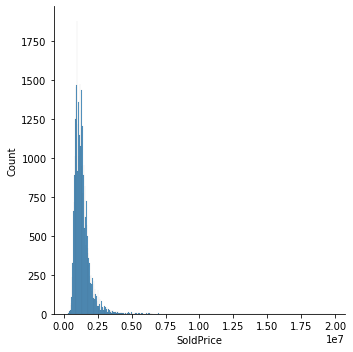

In [62]:
sns.displot( x="SoldPrice", data = houses_clean)

The outliers are shown to the right side of the data

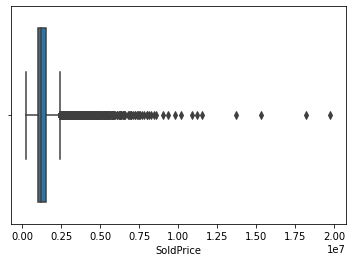

In [63]:
sns.boxplot(x=houses_clean["SoldPrice"])
plt.show()

 - Since I am not a millionaire(yet)for the purpose of my house hunting project I would be limiting the dataset to properties with 2 - 4 Bedrooms
- This falls within what I'm searching for, also its what's affordable for a lot of people my age(I think) given the craziness of the house market 
- Removing these will also help getting rid of possible outliers that could skew the mean which could affect the predictions

Lets remove those high number bedrooms to see if we can get a better distribution

In [20]:
aff_homes = houses_clean[houses_clean['Bed'].isin(range(2, 5))]

In [67]:
aff_homes['Bed'].value_counts()

3    19733
4    15542
2     1767
Name: Bed, dtype: int64

In [21]:
aff_homes.shape

(37042, 12)

Less outliers than before

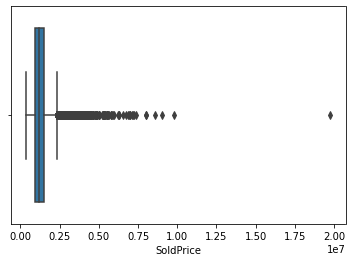

In [66]:
sns.boxplot(x=aff_homes["SoldPrice"])
plt.show()

Visualising the distribution of the numeric columns below. Looking at the price columns, I can see that the outliers are still skewing the distribution which may give misleading results in the end. I want to get it as close to a normal distribution as much as I can

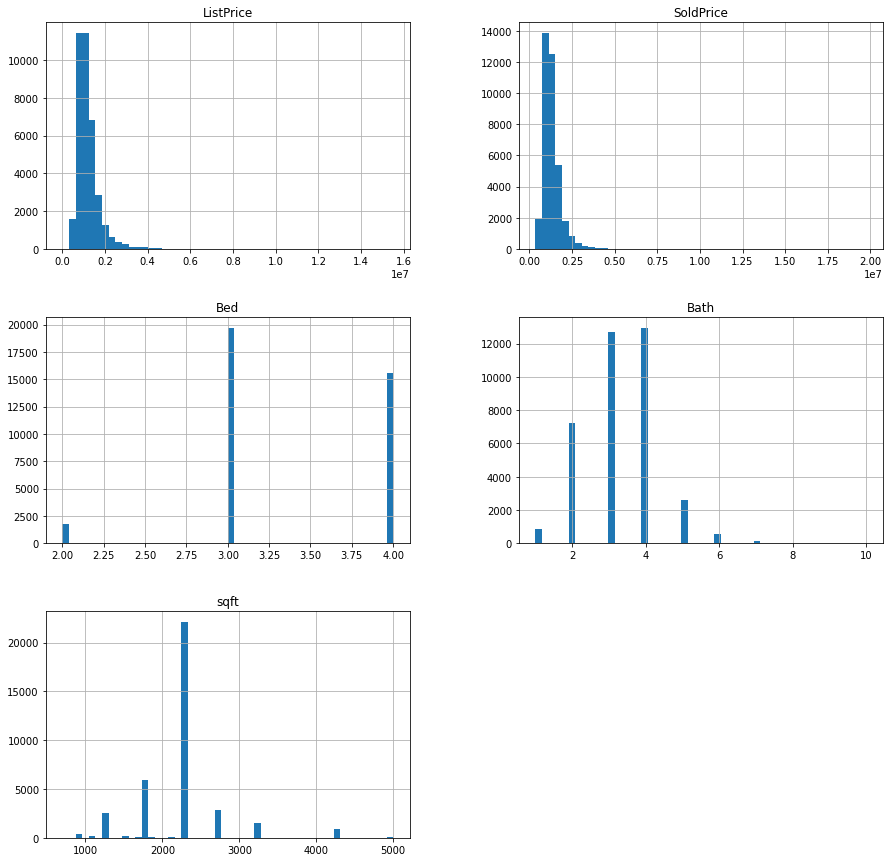

In [103]:
aff_homes.hist(bins=50, figsize=(15,15))
plt.ticklabel_format(style='plain')
#ax1.yaxis.get_offset_text().set_visible(False)
plt.show()


To deal with the outliers, I'll remove further outliers using the IQR filters where the median is used to get rid of outliers that are further away

In [22]:
# Removing the outliers
def removeOutliers(df, col):
    Q3 = np.quantile(df[col], 0.75)
    Q1 = np.quantile(df[col], 0.25)
    IQR = Q3 - Q1
    global outlier_free_list
    global filtered_data

    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in df[col] if ((x > lower_range) & (x < upper_range))]
    filtered_data = df.loc[df[col].isin(outlier_free_list)]

    
removeOutliers(aff_homes,'SoldPrice')
# Assigning filtered data back to our original variable
aff_homes = filtered_data
aff_homes.shape


(35481, 12)

Visualising the dataset after filtering outliers shows a better distribution of the dataset

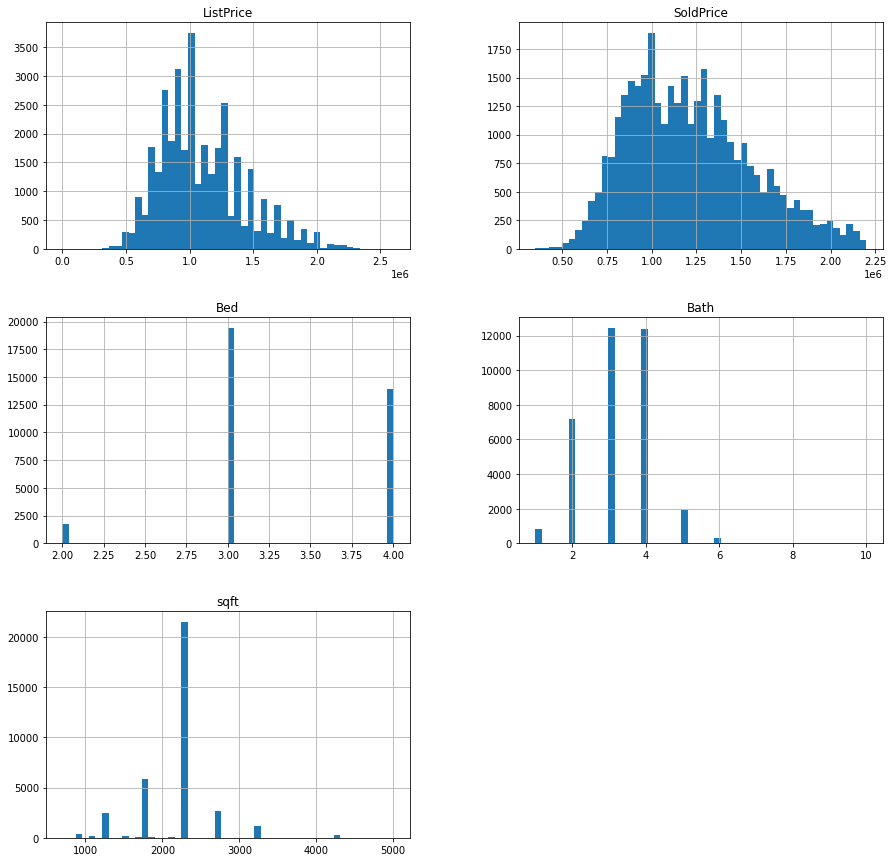

In [119]:

aff_h.hist(bins=50, figsize=(15,15))
plt.ticklabel_format(style='plain')
#ax1.yaxis.get_offset_text().set_visible(False)
plt.show()



Relationships - a pairplot is used to show relationships between the columns. There's a clear relationship is between listing price and sold price. I can see some relationship between soldPrice and square feet, the bigger the house the more expensive it is? Also depends on other features such as city. 

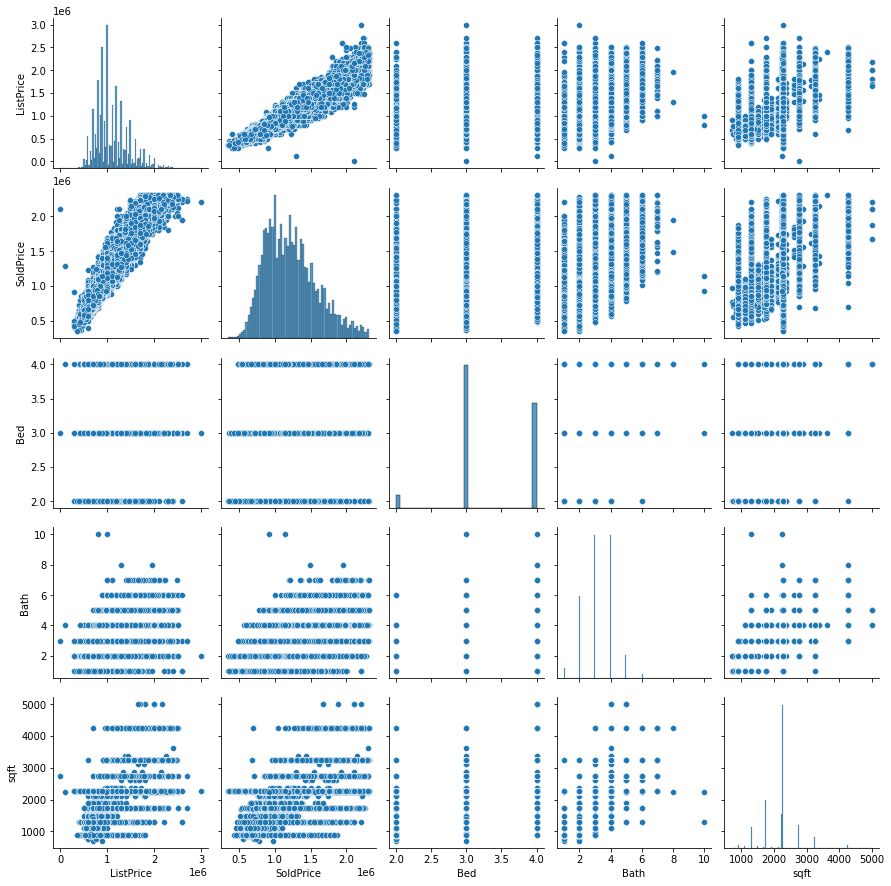

In [124]:
sns.pairplot(aff_homes)

Exploring property type and price, Houses seem to sell for more than condos. The townhomes and condos have outliers around the 2 million point which begs the question of whether there are areas where condos/townhomes are priced higher than the usual

<AxesSubplot:xlabel='Type', ylabel='SoldPrice'>

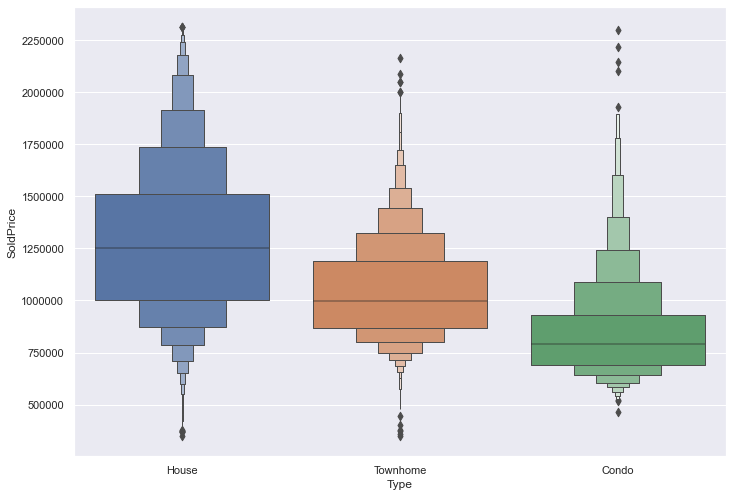

In [216]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

sns.boxenplot(x="Type", y="SoldPrice",data=aff_homes)

- Now lets bring in the city variable. 
- Markham, Vaughan, Richmond hill and oakville seems to have higher priced properties compared to a city like Oshawa where more of the property prices fall towards the lower side of the SoldPrice axis. Is that because there are more high priced houses being sold in Markham and Vaughan? (Because houses are more expensive or maybe the Condo and townhome price outliers are from these areas)

<AxesSubplot:xlabel='City', ylabel='SoldPrice'>

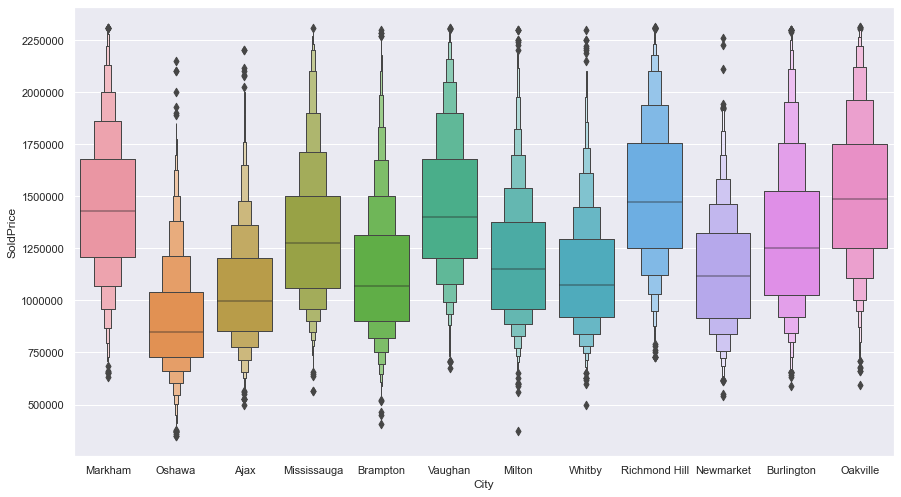

In [217]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.boxenplot(x="City", y="SoldPrice", data=aff_homes)

- Exploring percentages of property types. 
- Milton has a higher percentage of Townhomes sold than houses compared to other cities where the percentages of Townhomes sold are way less than the houses for example Mississauga. Still doesn't explain those cities with high prices. Lets keep exploring 

<AxesSubplot:xlabel='City'>

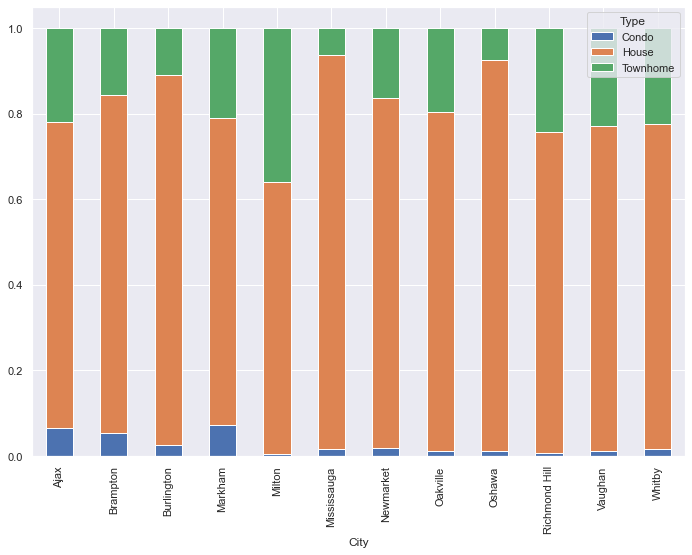

In [260]:


(pd.crosstab(aff_homes['City'],aff_homes['Type'], 
             normalize='index')
   .plot.bar(stacked=True)
)

- Median property price gives a good representation of property prices in a certain region. Median is less likely to be affected by outliers unlike the mean.
- I can see that houses are more expensive in all cities than condos and townhomes. This graph further confirms what was seen with the box plot that Oshawa has cheaper houses compared to other cities. The median house price in Oakville is around 1.6M but in Oshawa this is around 850K

- Question. Why are oakville, Markham, Vaughan, Richmond hill houses so high in price? Lets find the median income in these areas and compare

<AxesSubplot:xlabel='City', ylabel='SoldPrice'>

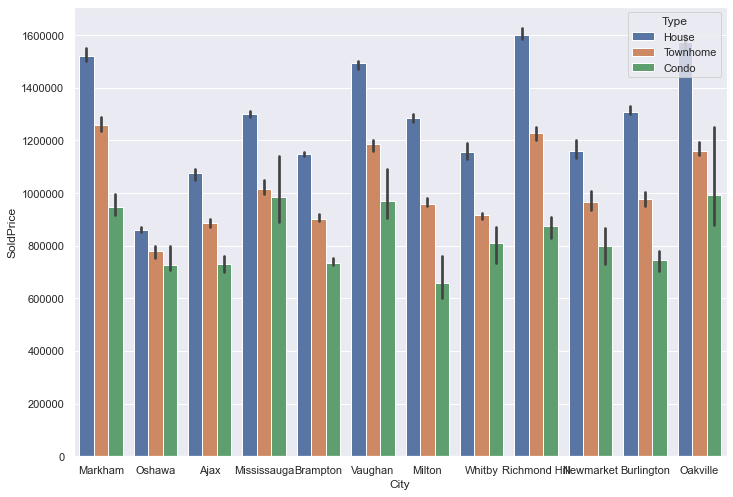

In [219]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.barplot(x="City", y="SoldPrice", hue="Type", data=aff_homes, estimator=np.median)

**Feature Engineering**
- To help with more insights, more features will be included like Median Income per city, and categories such as Property Type, City, Month Sold will be turned into numerical features using dummy variables

Adding median income for each city

In [23]:
#data gotten from stat canada
data = {'City':['Oshawa','Ajax','Brampton','Burlington','Markham','Milton','Mississauga','Newmarket','Oakville','Richmond Hill','Vaughan','Whitby'],
        'median_income':[70211,96949,87290,93588,89028,104730,83018,95489,113666,88353,105351,103809]}
med_income = pd.DataFrame.from_dict(data)     
        
        
        

In [68]:
#merge median income to property data
aff_homes_c = aff_homes.merge(med_income, how = 'inner', on ='City')

In [69]:
#find median sold price for each city
city_med = aff_homes_c.groupby('City')['SoldPrice'].median()
city_med = city_med.reset_index().sort_values(['SoldPrice'],ascending=False).set_index(['City'])
city_med.reset_index(inplace = True)
city_med.rename({'SoldPrice':'median_soldPrice'}, axis=1,inplace=True)
city_med.head()

,City,median_soldPrice
0,Oakville,1485000
1,Richmond Hill,1470000
2,Markham,1428000
3,Vaughan,1400000
4,Mississauga,1275000


In [70]:
#find median list price for each city
city_medList = aff_homes_c.groupby('City')['ListPrice'].median()
city_medList = city_medList.reset_index().sort_values(['ListPrice'],ascending=False).set_index(['City'])
city_medList.reset_index(inplace = True)
city_medList.rename({'ListPrice':'median_Listprice'}, axis=1,inplace=True)
city_medList.head()

,City,median_Listprice
0,Oakville,1389000
1,Richmond Hill,1300000
2,Vaughan,1298000
3,Markham,1238000
4,Mississauga,1149900



- Looking at the table below. Even though Oshawa has lower priced properties compared to the other cities, the difference in median list and soldPrice is a lot! This goes to show that ones needs a lot more than the listed price to buy a house in Oshawa. 

- Oakville's list prices and sold prices don't have a huge difference and this is probably because the median income over there is higher, its a place with wealthy people so the house will get sold at a high price anyway. 

- In Oshawa, sellers probably list their house for way less because they want a lot of buyers to bid because listing it at a higher price may attract no buyers.

In [71]:
medianListSold = pd.merge(left=city_medList, right=city_med, how='inner', on='City')
medianListSold['perc_change'] = (medianListSold.median_soldPrice - medianListSold.median_Listprice) / medianListSold.median_Listprice * 100
medianListSold.head(13).sort_values(by=['perc_change'],ascending=False)

,City,median_Listprice,median_soldPrice,perc_change
11,Oshawa,699900,850000,21.445921
9,Whitby,899000,1073000,19.354839
10,Ajax,849900,995000,17.072597
3,Markham,1238000,1428000,15.347334
6,Milton,999900,1150000,15.011501
5,Burlington,1099900,1253000,13.919447
1,Richmond Hill,1300000,1470000,13.076923
7,Newmarket,998000,1115000,11.723447
4,Mississauga,1149900,1275000,10.879207
8,Brampton,989000,1070005,8.190597


In [72]:
#merge median sold price to property data
aff_homes_c = pd.merge(left=aff_homes_c, right=city_med[['City', 'median_soldPrice']], how='right', on='City')
aff_homes_c.head()

,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft,City,Neighbourhood,SoldDate,month_year,median_income,median_soldPrice
0,498 Charles Potter Lane,House,1920000,1900000,1 month,3,4,2250.000000,Oakville,Rural Oakville L6M 0P6,2022-03-30,2022-03,113666,1485000
1,1488 Thorncrest Cres,House,1929900,1930000,1 month,4,4,2750.000000,Oakville,West Oak Trails L6M3Z1,2022-03-30,2022-03,113666,1485000
2,2172 Whitworth Dr,Townhome,1099000,1325000,6 days,3,4,2283.266777,Oakville,Palermo West L6M 0A7,2022-04-24,2022-04,113666,1485000
3,3046 Portree Cres,House,1499000,1700000,1 Month,4,4,1750.000000,Oakville,Palermo West L6M5C4,2022-03-30,2022-03,113666,1485000
4,1172 Lansdown Dr,House,1990000,2050000,6 days,4,4,2750.000000,Oakville,Clearview L6J7N7,2022-04-24,2022-04,113666,1485000


- Looking at the chart below , median income seems to be in close range for all cities however some cities that have a higher median income have high priced houses e.g oakville, Richmond hill
- This could provide some explanation as to why properties in certain areas are so high compared to others

<AxesSubplot:xlabel='City'>

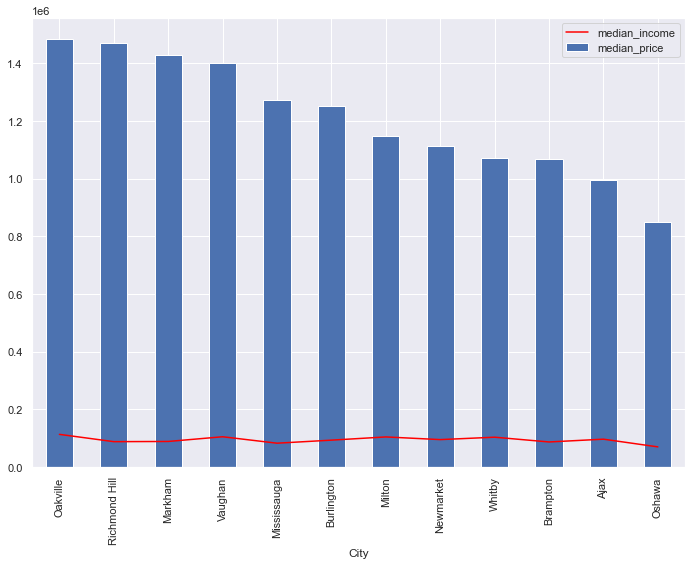

In [291]:

ax = aff_homes_f.plot(x='City', y='median_income',color='red')
aff_homes_f.plot(x='City', y='median_price', kind='bar',ax=ax)

Percentage difference between listprice and soldprice

In [73]:
aff_homes_c['perc_change'] = (aff_homes_c.SoldPrice - aff_homes_c.ListPrice) / aff_homes_c.ListPrice * 100

In [74]:
aff_homes_c.head()

,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft,City,Neighbourhood,SoldDate,month_year,median_income,median_soldPrice,perc_change
0,498 Charles Potter Lane,House,1920000,1900000,1 month,3,4,2250.000000,Oakville,Rural Oakville L6M 0P6,2022-03-30,2022-03,113666,1485000,-1.041667
1,1488 Thorncrest Cres,House,1929900,1930000,1 month,4,4,2750.000000,Oakville,West Oak Trails L6M3Z1,2022-03-30,2022-03,113666,1485000,0.005182
2,2172 Whitworth Dr,Townhome,1099000,1325000,6 days,3,4,2283.266777,Oakville,Palermo West L6M 0A7,2022-04-24,2022-04,113666,1485000,20.564149
3,3046 Portree Cres,House,1499000,1700000,1 Month,4,4,1750.000000,Oakville,Palermo West L6M5C4,2022-03-30,2022-03,113666,1485000,13.408939
4,1172 Lansdown Dr,House,1990000,2050000,6 days,4,4,2750.000000,Oakville,Clearview L6J7N7,2022-04-24,2022-04,113666,1485000,3.015075


In [75]:
#extract month text 

aff_homes_c['soldMonth'] = pd.to_datetime(aff_homes_c['SoldDate']).dt.month
aff_homes_c['soldMonth'] = aff_homes_c['soldMonth'].apply(lambda x: calendar.month_abbr[x])
aff_homes_c.head()




,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft,City,Neighbourhood,SoldDate,month_year,median_income,median_soldPrice,perc_change,soldMonth
0,498 Charles Potter Lane,House,1920000,1900000,1 month,3,4,2250.000000,Oakville,Rural Oakville L6M 0P6,2022-03-30,2022-03,113666,1485000,-1.041667,Mar
1,1488 Thorncrest Cres,House,1929900,1930000,1 month,4,4,2750.000000,Oakville,West Oak Trails L6M3Z1,2022-03-30,2022-03,113666,1485000,0.005182,Mar
2,2172 Whitworth Dr,Townhome,1099000,1325000,6 days,3,4,2283.266777,Oakville,Palermo West L6M 0A7,2022-04-24,2022-04,113666,1485000,20.564149,Apr
3,3046 Portree Cres,House,1499000,1700000,1 Month,4,4,1750.000000,Oakville,Palermo West L6M5C4,2022-03-30,2022-03,113666,1485000,13.408939,Mar
4,1172 Lansdown Dr,House,1990000,2050000,6 days,4,4,2750.000000,Oakville,Clearview L6J7N7,2022-04-24,2022-04,113666,1485000,3.015075,Apr


In [77]:
#select relevant columns
aff_homes_num =aff_homes_c[['Type','ListPrice','SoldPrice','Bed','Bath','sqft','City','median_income','soldMonth']]

In [78]:
#dummy variables to convert categorical features into numerical ones 
aff_homes_num = pd.get_dummies(aff_homes_num, columns=['Type','City','soldMonth'])

- Doing a correlation against soldPrice, I can see a strong correlation between number of Baths and price. So the higher the number of Baths the higher the price
- Also sqft makes sense as bigger houses are more expensive
- Its interesting to see February correlating with the sold price, this means February 2022 (data only contains sold properties from Apr 2021 - Apr 2022) saw a lot of houses with high prices sold
- Median income is also an interesting factor, a high median income means the area is for the wealthy which means they can afford to buy the expensive houses. 

In [103]:
#correlation of features against the target
corrl = aff_homes_num[aff_homes_num.columns[0:]].corr()['SoldPrice'][:-1].sort_values(ascending=False)
corrl

SoldPrice             1.000000
ListPrice             0.932634
Bath                  0.521500
Bed                   0.489529
sqft                  0.473762
Type_House            0.301153
median_income         0.261605
City_Richmond Hill    0.191354
City_Markham          0.183033
City_Vaughan          0.181465
soldMonth_Feb         0.177858
City_Oakville         0.177771
soldMonth_Jan         0.156320
City_Mississauga      0.089500
soldMonth_Mar         0.069903
soldMonth_Dec         0.062982
City_Burlington       0.048920
soldMonth_Nov         0.034491
soldMonth_Oct         0.020380
City_Milton          -0.024626
soldMonth_Aug        -0.033598
City_Newmarket       -0.039174
soldMonth_Jul        -0.060421
City_Whitby          -0.070410
soldMonth_Jun        -0.089735
soldMonth_May        -0.101311
City_Ajax            -0.118679
soldMonth_Apr        -0.126933
City_Brampton        -0.166156
Type_Condo           -0.192606
Type_Townhome        -0.231547
City_Oshawa          -0.301910
Name: So

### Modelling

- I will be using a linear regression model to evaluate the relationship between all features and the SoldPrice(target). 

In [204]:
#select feature variable(x) and target variable(y)
X = aff_homes_num.drop(['SoldPrice'],axis=1)
y = aff_homes_num['SoldPrice']

In [81]:
#do a test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=101)

In [82]:

#create an instance of linear regression
lm = LinearRegression()
#train and fit the data 
lm.fit(X_train,y_train)

LinearRegression()

In [83]:
# print the intercept
print(lm.intercept_)

-17808.01436649449


- Looking at the coefficents below helps to understand the impact of each variable on the Target feature. 
- Intepreting this for the Markham variable, with all features fixed, a unit increase in Markham houses will lead to an increase of 69,827 dollars. Meaning Markham houses are associated with expensive prices  
- Interestingly the median income does not seem to impact the SoldPrice as much as I expected. 

In [100]:
#coefficient
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df.sort_values(by = 'Coefficient', ascending=False)

,Coefficient
soldMonth_Jan,131919.039134
soldMonth_Feb,102022.630008
soldMonth_Dec,71720.162630
City_Markham,69827.836759
City_Richmond Hill,50246.353167
Type_House,40690.534029
soldMonth_Mar,36621.869835
Bed,32365.258716
soldMonth_Nov,30131.693471
Bath,29095.167734


In [85]:
#predict test data    
predictions =lm.predict(X_test)

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='SoldPrice'>

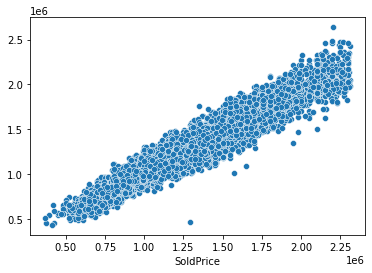

In [86]:
#plot real values against prediction
sns.scatterplot(y_test, predictions )

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


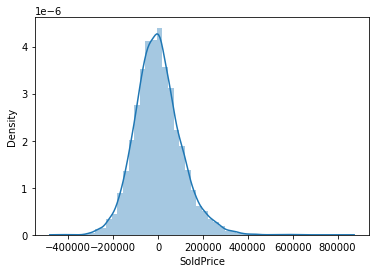

In [87]:
#plot residuals 
sns.distplot((y_test-predictions),bins=50);

In [88]:

#print errors 
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))




MAE: 79438.67605156841
MSE: 10673411297.717093
RMSE: 103312.20304357608


In [89]:
#check the score 
lm.score(X_test,y_test)

0.917736284277334

In [92]:
#save model for future use
filename = 'finalized_model.sav'
pickle.dump(lm, open(filename, 'wb'))

- Although the score looks good, the errors are high, the errors simply depict how far away from the real observations the predictions were. Having a high number says the predictions are far away.

- Lets reduce the error using a different method - Gradient descent. 

- Gradient Descent aims to reduce a variable called the cost function- MSE
- The cost function in gradient descent represents the error between the predicted and expected values(basically MSE). With gradient descent, we iteratively modify the parameters and calculate a new cost function. The goal in the end is to reduce the cost function for a better prediction

In [166]:
#calculate the cost function 
def costfunc(h, y):
    sq_error = (h - y)**2
    n = len(y)
    return 1.0 / (2*n) * sq_error.sum()



In [167]:
#gradient descent algorithm
class LR:
    def predict(self, X):
        return np.dot(X, self._W)
                          

    def _gradient_descent_step(self, X, y, lr):

        predictions = self.predict(X)
    
        error = predictions - y
        gradient = np.dot(X.T,  error) / len(X)

        self._W -= lr * gradient
      
    def fit(self, X, y, n_iter=100000, lr=0.01):

        self._W = np.zeros(X.shape[1])

        self._cost_history = []
        self._w_history = [self._W]
        for i in range(num_iter):
      
            prediction = self.predict(X)
            cost = costfunc(prediction, y)
        
            self._cost_history.append(cost)
        
            self._gradient_descent_step(x, y, lr)
        
            self._w_history.append(self._W.copy())
        return self

Feature scaling will be used to normalise the features as they are of different magnitudes e.g bed is 2 -5 and sqft is in the thousands 

In [286]:
#feature scaling for gradient descent
x = aff_homes_num.drop(['SoldPrice'],axis=1)
y = aff_homes_num['SoldPrice']

x= (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 

In [215]:
ling = LinearRegression()
#fit the data
ling.fit(x, y, n_iter=200, lr=0.1)


In [207]:
#check coefficients
ling._W

array([1229080.67978434,  272932.59865554,   18964.34911618,
         28909.61331721,   16185.64941845,    8384.53355522,
         -8542.36427073,   10947.23541   ,   -7694.10048434,
         -2602.7802138 ,  -22557.22336789,    6800.48694474,
         21073.72852208,   -4612.1414004 ,    3670.99965266,
         -4847.71770271,    9352.1647428 ,   -6675.14445743,
         13429.72327567,    2392.54267421,    1272.33700033,
        -18435.79709692,   -9015.62203128,   14925.69946987,
         33905.70594286,   37500.2787059 ,  -16191.27116722,
        -21084.84308036,   10170.63106932,  -22026.16603717,
          9787.89100927,    4139.27029208,   -3981.72956279])

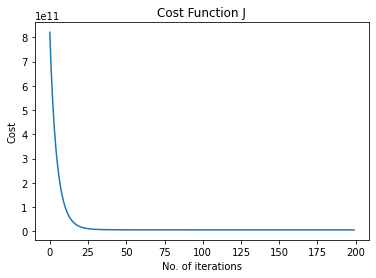

In [216]:
#plot the cost function to see how it converges 
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(ling._cost_history)
plt.show()

In [218]:
#the optimal cost function value( MSE) . which is lower than the MSE from the Sklearn Linear regression implemented earlier
ling._cost_history[-1]

5341106993.672845